<h1> <center> PPOL564 | Data Science 1 | Foundations</center></h1>
<h2> <center> Interpretable Machine Learning Walkthrough </center></h2>

# Overview

The aim is to extract insights from using a statistical learning model to better understand who does and does not have healthcare coverage. 

# Dependencies 

In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

# Data 

The following data contains information regarding whether or not someone has health coverage (`coverage`). The available predictive features capture socio-economic and descriptive factors.

> _Note_: We'll only take a subset of this data so that the models will run faster, but feel free to explore on the entire data set.

In [2]:
dat = pd.read_csv("health-coverage.csv").sample(n=5000,random_state=123)

In [3]:
dat.head()

,coverage,age,wage,cit,mar,educ,race
2431,No_Coverage,29,12000,Citizen,Never Married,HS Degree,White
611,No_Coverage,56,120000,Citizen,Divorced,HS Degree,White
1779,No_Coverage,28,18200,Citizen,Divorced,HS Degree,White
15518,Coverage,29,0,Citizen,Never Married,HS Degree,Black
10878,No_Coverage,51,0,Citizen,Widowed,HS Degree,White


In [4]:
dat.dtypes

coverage    object
age          int64
wage         int64
cit         object
mar         object
educ        object
race        object
dtype: object

Convert categorical variables to categories.

In [5]:
for col in ['cit', 'mar', 'educ', 'race']:
    dat[col] = dat[col].astype('category')

## Missingness?

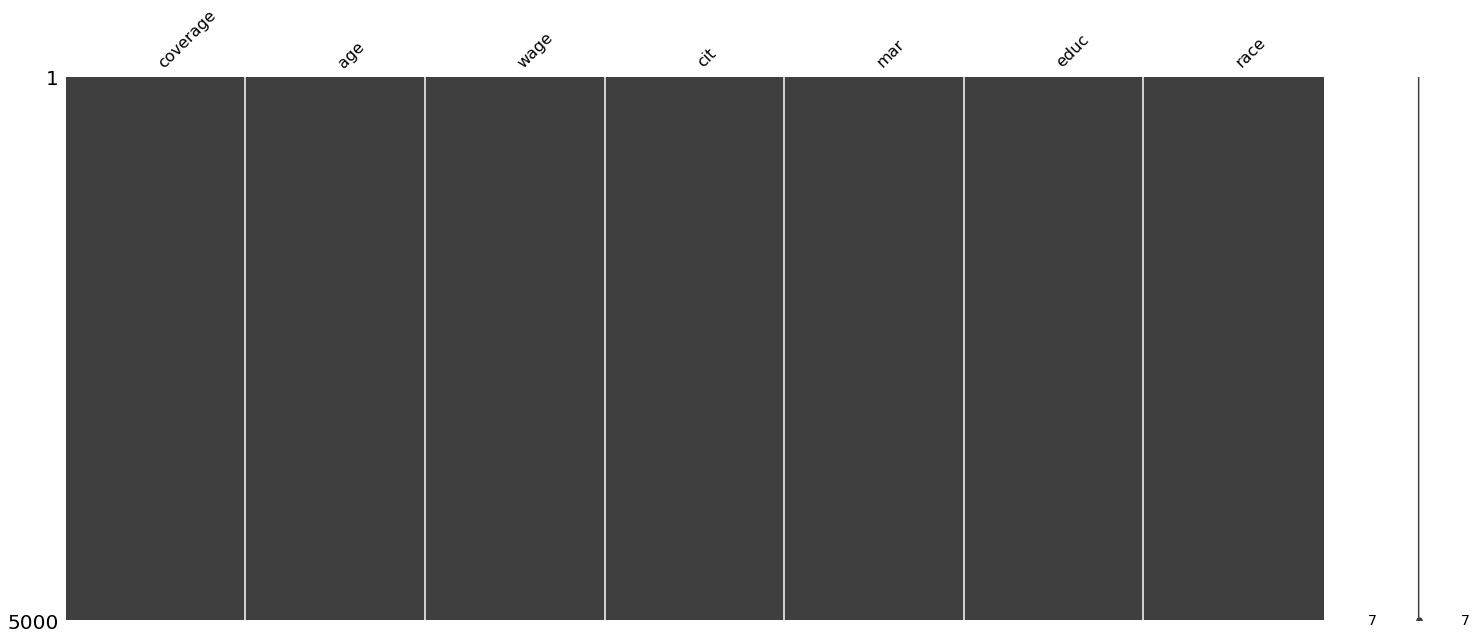

In [6]:
miss.matrix(dat) # None

## Split

In [7]:
y = dat[['coverage']]
X = dat.drop(columns=['coverage'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [8]:
print(train_X.shape[0]/dat.shape[0])
print(test_X.shape[0]/dat.shape[0])

0.75
0.25


## Explore Training Set

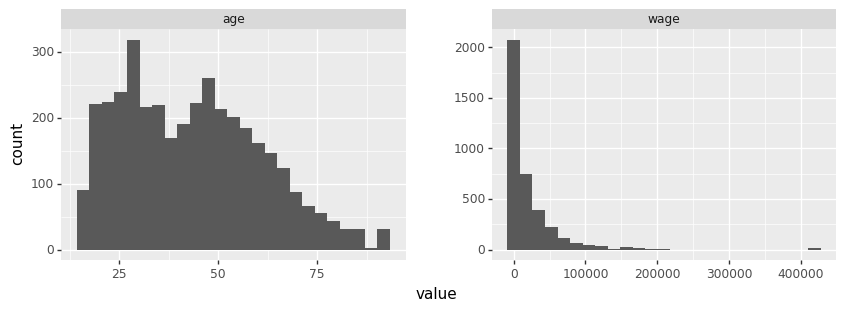

<ggplot: (8771162986658)>

In [9]:
# Plot the continuous Variables 
d = train_X.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

Things to note: 
- Looks like there is a right skew in wage. Consider log transforming. 

Now, let's look at the **categorical** predictors

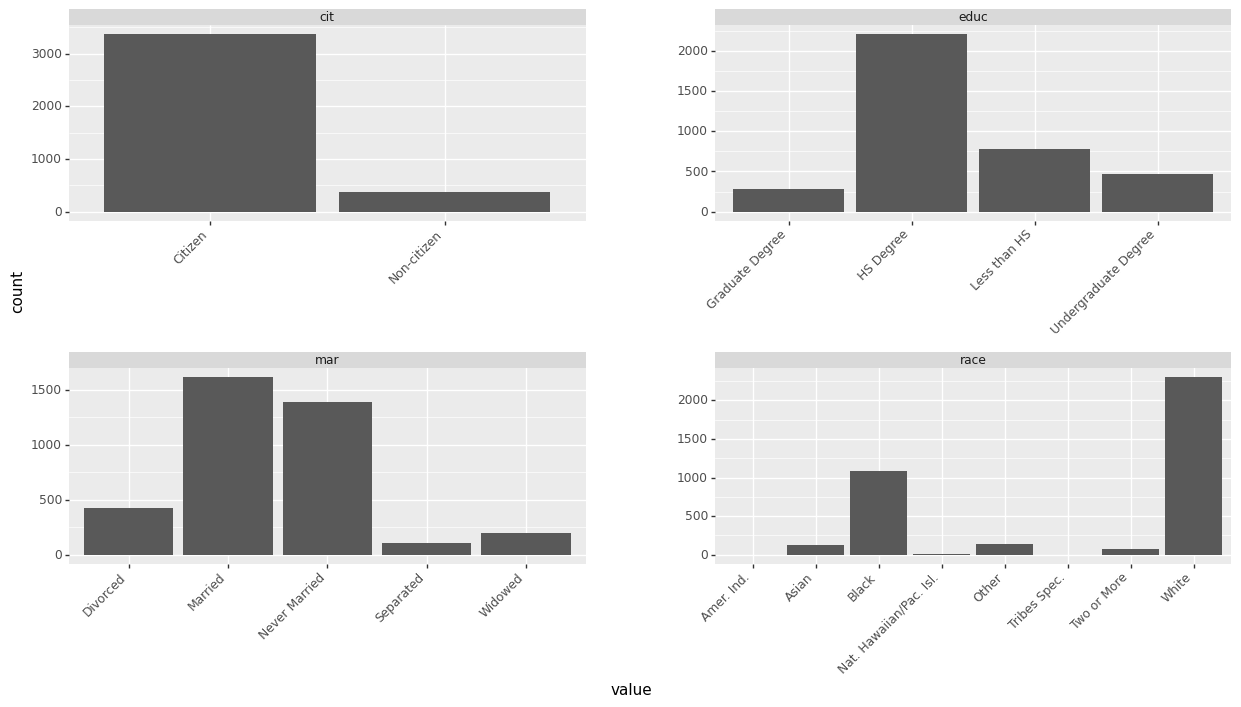

<ggplot: (-9223363265691757589)>

In [10]:
d = train_X.select_dtypes(include="category").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

Things to note:

- Some of these categories possess an intrinsic ordering (`educ`)
- Others do not (`mar`/`race`)

# Preprocessing 

- Need to convert all categorical variables in the data to numeric values (of some sort)
- Need to log transform `wage`.
- Need to scale the continuous variables (`age` and `wage`)

### High-Level Preprocessing

There are high-level transformation we want to impose on training and test data. These transformations don't require that use any information from the test data (i.e. a mean, a min, etc). Rather there are some formatting changes/transformations that will make our lives easier downstream. 

#### `educ`
Impose an ordering on the education levels.

In [11]:
ed_cats = ['Less than HS','HS Degree','Undergraduate Degree','Graduate Degree']
cat_types = CategoricalDtype(categories=ed_cats,ordered=True)
dat['educ'] = dat['educ'].astype(cat_types)
dat['educ'].value_counts()

HS Degree               2932
Less than HS            1042
Undergraduate Degree     647
Graduate Degree          379
Name: educ, dtype: int64

Let's convert this category into a numeric variable.

In [12]:
dat['educ'] = dat['educ'].cat.codes
dat['educ'].value_counts()

1    2932
0    1042
2     647
3     379
Name: educ, dtype: int64

This is the only way we can **ensure** the correct ordering. Don't trust an encoder (i.e.. `OrdinalEncoder` to get it right).

#### `wage`

Next, let's log `wage`. Note that we add an offset because we have zeros in the data. (log of zero is negative infinity)

In [13]:
dat['wage'] = np.log(dat['wage'] + 1)

####  `race`

Let's collapse the racial categories. For some of the categories, there is very little representation in the data. By collapsing, we increase these bin sizes.

In [14]:
dat.race.value_counts()

White                      3060
Black                      1467
Other                       177
Asian                       171
Two or More                 106
Tribes Spec.                  7
Amer. Ind.                    7
Nat. Hawaiian/Pac. Isl.       5
Name: race, dtype: int64

In [15]:
dat['white'] = 1*(dat['race'] == "White")
dat['black'] = 1*(dat['race'] == "Black")
# Everyone else ("other") is the baseline. 

In [16]:
# Drop race
dat = dat.drop(columns=["race"])

#### `mar`
Convert categories to dummies 

In [17]:
mar_dummies = pd.get_dummies(dat.mar)
mar_dummies.columns = [c.lower().replace(" ","_") for c in mar_dummies.columns]
mar_dummies = mar_dummies.drop(['never_married'],axis=1) # Baseline
mar_dummies.head(5)

,divorced,married,separated,widowed
2431,0,0,0,0
611,1,0,0,0
1779,1,0,0,0
15518,0,0,0,0
10878,0,0,0,1


In [18]:
dat = pd.concat([dat.drop(['mar'],axis=1),mar_dummies],axis=1)
dat.head()

,coverage,age,wage,cit,educ,white,black,divorced,married,separated,widowed
2431,No_Coverage,29,9.392745,Citizen,1,1,0,0,0,0,0
611,No_Coverage,56,11.695255,Citizen,1,1,0,1,0,0,0
1779,No_Coverage,28,9.809232,Citizen,1,1,0,1,0,0,0
15518,Coverage,29,0.000000,Citizen,1,0,1,0,0,0,0
10878,No_Coverage,51,0.000000,Citizen,1,1,0,0,0,0,1


#### `cit`
Convert to a dummy variable.

In [19]:
dat['cit'].value_counts()

Citizen        4499
Non-citizen     501
Name: cit, dtype: int64

In [20]:
dat['cit'] = 1*(dat['cit'] == "Citizen")

In [21]:
dat['cit'].sum()

4499

####  `coverage`

Finally, our outcome `coverage` needs to be numeric (0/1)

In [22]:
dat['coverage'] = 1*(dat['coverage']=='Coverage')

### Re-split

We learned that we had to make these changes from the training data. Now, let's re-split using the changed data. 

In [23]:
y = dat[['coverage']]
X = dat.drop(columns=['coverage'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

# Train Models

### Cross Validation 

In [24]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

## Initialize Pipeline

Note that we still want to scale values, but we want to do this in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [25]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

As before, the grid search to tune the models is pretty tame here so that the code will run quickly. Often a good idea to explore more of the tuning parameter space when running your own code. 

In [26]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__n_estimators':[1000,1500]}
    
]

## Run Models

Put it all together in a GridSearch

In [27]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

And Run

In [28]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier(n_neighbors=25)],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier()],
                          'model__n_estimators': [1000, 1500]}],
             scoring='roc_auc')

Best ROC AUC.

In [29]:
search.best_score_

0.7908197600983105

In [30]:
search.best_params_

{'model': KNeighborsClassifier(n_neighbors=25), 'model__n_neighbors': 25}

In [31]:
knn_mod = search.best_estimator_

### Performance

In [32]:
m.roc_auc_score(train_y,knn_mod.predict_proba(train_X)[:,1])

0.8263020577712339

In [33]:
m.accuracy_score(train_y,knn_mod.predict(train_X))

0.7365333333333334

# Model Interpretation

In [34]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

## Permutation Importance

### with `sklearn`

Import the permutation importance with from the `sklearn.inspection` module.

In [35]:
from sklearn.inspection import permutation_importance

Permute the features to determine importance. Note here that I only do this 5 times for the sake of runtime, but you'd want to do this more (e.g. 25 times)

In [36]:
vi = permutation_importance(knn_mod,train_X,train_y,n_repeats=5)

Organize the output as a data frame. 

In [37]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.075840,0.005208,0.065424,0.086256
1,married,0.053813,0.005114,0.043586,0.064041
2,wage,0.051307,0.002815,0.045677,0.056937
3,educ,0.050027,0.004745,0.040536,0.059517
4,cit,0.032213,0.002364,0.027486,0.036940
5,widowed,0.030240,0.000933,0.028374,0.032106
6,white,0.022133,0.002343,0.017447,0.026819
7,black,0.019093,0.003540,0.012013,0.026174
8,divorced,0.009920,0.000798,0.008324,0.011516
9,separated,0.000587,0.000459,-0.000331,0.001504


Visualize

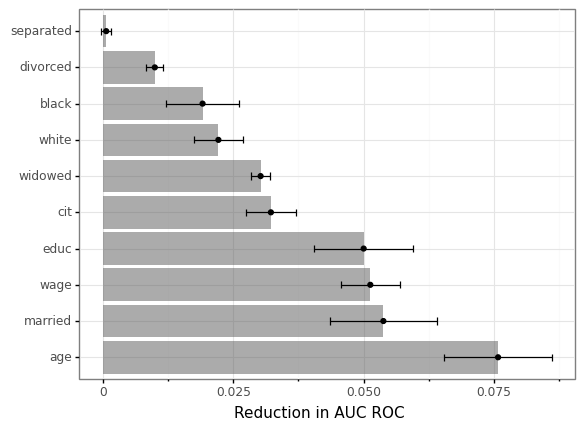

<ggplot: (-9223363265674289671)>

In [38]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

### with `eli5`

In [39]:
import eli5 # "explain it to me like I'm 5"
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


Initialize the `PermutationImportance` class object. 

In [40]:
perm_train = PermutationImportance(knn_mod,
                                   n_iter=5,random_state=123)

Fit it using the train (or test!) data

In [41]:
perm_train.fit(train_X,train_y)

PermutationImportance(estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                                ('model',
                                                 KNeighborsClassifier(n_neighbors=25))]),
                      random_state=123)

We can immediately extract the weights as a data frame. 

In [42]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(train_X))
vi2

,feature,weight,std
0,age,0.076907,0.006397
1,educ,0.051360,0.003500
2,married,0.050773,0.003135
3,wage,0.049653,0.005080
4,cit,0.033120,0.003697
5,widowed,0.030987,0.001111
6,white,0.018933,0.003012
7,black,0.018667,0.000446
8,divorced,0.010720,0.001748
9,separated,0.001440,0.000644


We can then just plot as we did above. 

## Partial Dependency Plots

### with `sklearn`

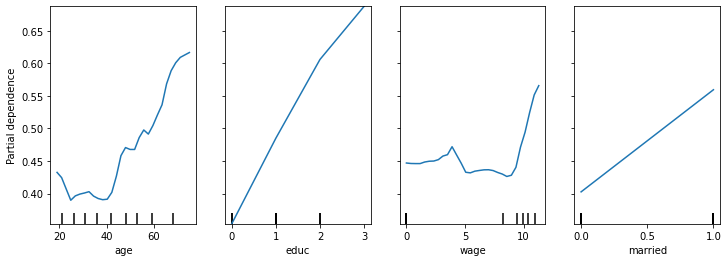

In [43]:
# Target specific features
features = ['age','educ','wage','married']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    knn_mod, train_X, features,n_cols=4,
    n_jobs=4, grid_resolution=30,ax=ax
)

Interaction Partial Dependency Plots (2D)

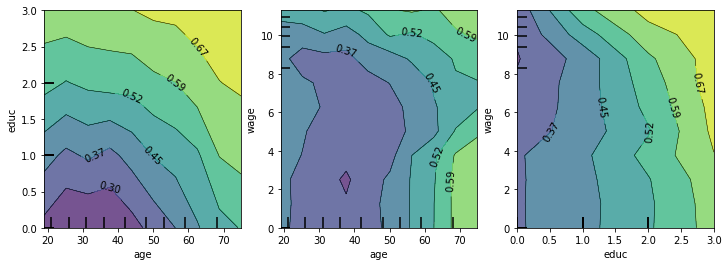

In [44]:
# Feed in the ineraction as a nested list
interacted_features = [['age','educ'],['age','wage'],['educ','wage']] 

# Then business as usual when plotting
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    knn_mod, train_X, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=10,ax=ax
)

### with `pdpbox`

In [45]:
from pdpbox import pdp

With this model, we first fit the partial dependencies. 

In [46]:
pdp_dist = pdp.pdp_isolate(model = knn_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="age")

Then plot them.

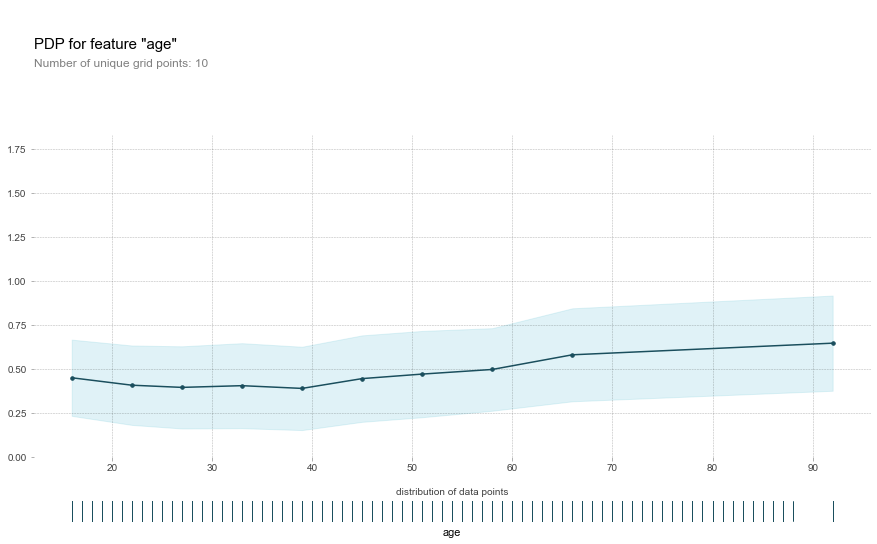

In [47]:
fig,ax = pdp.pdp_plot(pdp_dist,'age',plot_pts_dist=True,center=False,)

Interaction Partial Dependency Plots (2D)

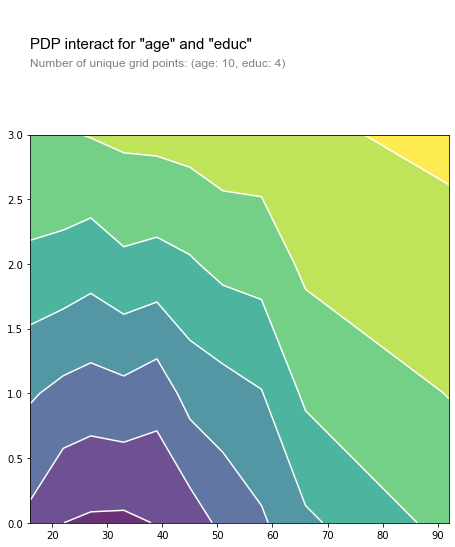

In [48]:
inter1  =  pdp.pdp_interact(model = knn_mod, 
                            dataset = train_X,
                            model_features = train_X.columns,
                            features=["age",'educ'])

# Using a try-except clause due to a dependency error. Not ideal, but want to show the api. 
try:
    fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                                   feature_names=["age",'educ'],
                                   plot_type="contour")
except:
    print("")

We can also plot the interactions as a grid (which are more interpretable)

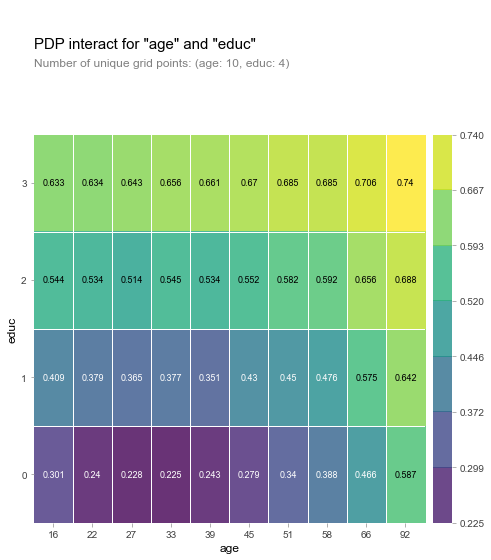

In [49]:
fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                               feature_names=["age",'educ'],
                               plot_type="grid")

## ICE Plots

### with `pdpbox`

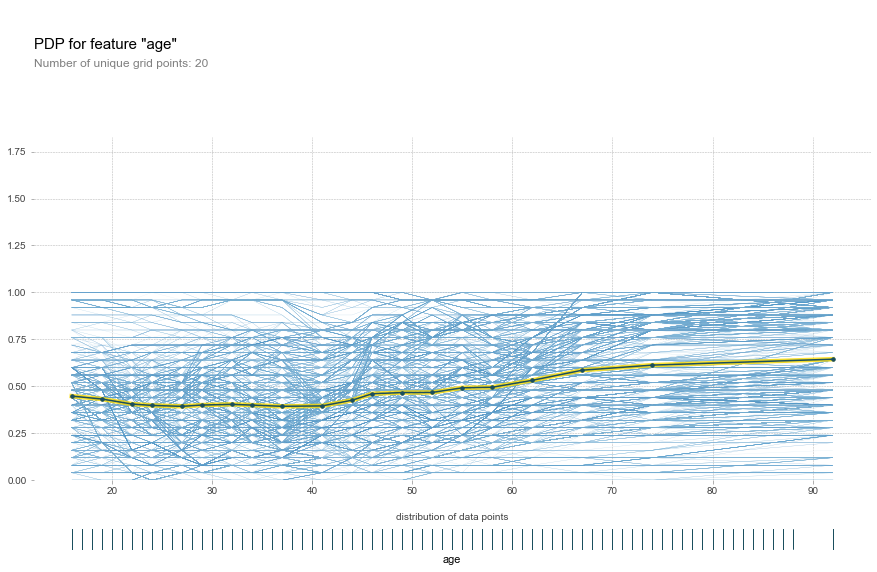

In [50]:
pdp_dist = pdp.pdp_isolate(model = knn_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="age",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'age',plot_pts_dist=True,
                      center=False,plot_lines=True, # ICE part                          
                      figsize=(15,10))

It can be difficult to interpret ICE plots because each observation possess different baselines. We can get around this by **centering** the plot around the baseline (minimum) value of the variable of interest. 

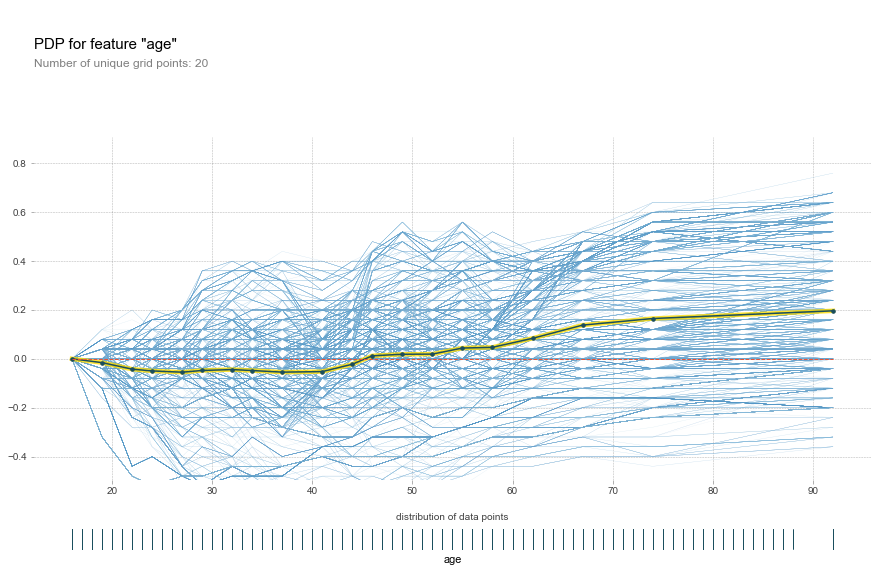

In [51]:
pdp_dist = pdp.pdp_isolate(model = knn_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="age",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'age',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

Let's now generate a couple of these

In [52]:
def gen_ice_plot(var_name = "age"):
    pdp_dist = pdp.pdp_isolate(model = knn_mod, 
                               dataset = train_X,
                               model_features = train_X.columns.tolist(),
                               feature=var_name)

    fig,ax = pdp.pdp_plot(pdp_dist,var_name,plot_pts_dist=True,
                          center=True,plot_lines=True)

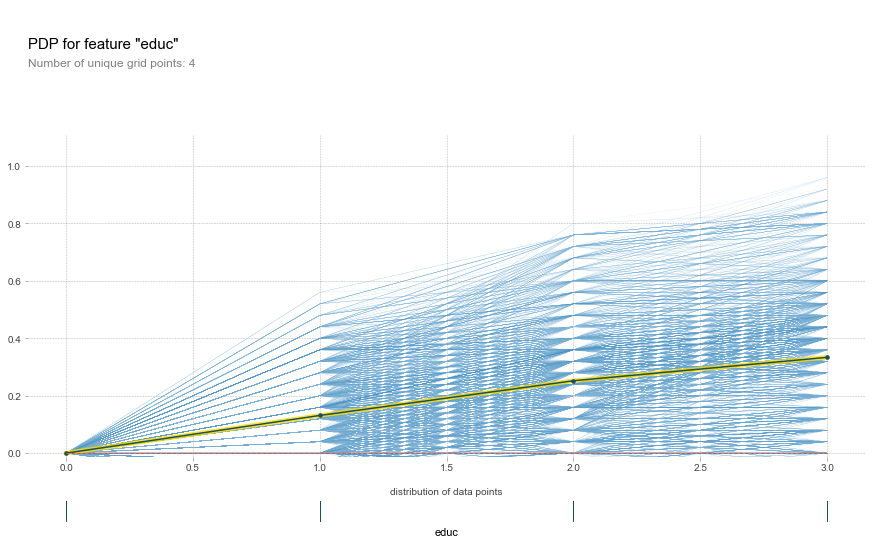

In [53]:
gen_ice_plot(var_name = "educ")

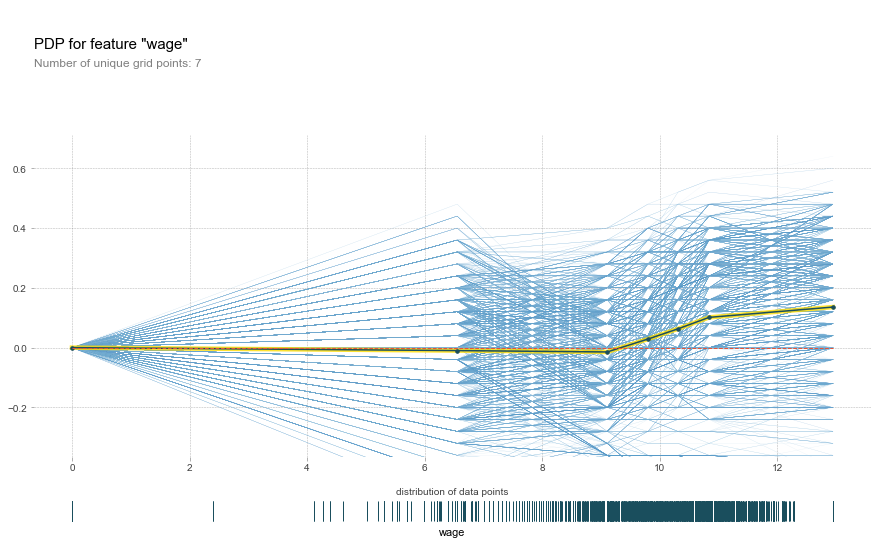

In [54]:
gen_ice_plot(var_name = "wage")